# Classification Analysis of Chat GPT-5 and Cloude Sonnet 4-5 Model Generations

This notebook processes the generated text from the Chat GPT-5 and Cloude Sonnet 4-5 models and classifies each generation using an API endpoint. The classification determines whether the text is 'Técnico' (Technical) or 'Plano' (Plain language).

## Workflow:
1. Read the CSV file with model generations
2. Extract values from `generated_claude-sonnet-4-5` and `generated_chatgpt-5` columns
3. Send POST requests to the classification API
4. Collect predictions and save to a new CSV file
5. Perform data analysis and create visualizations

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Step 1: Load and Explore the Data

First, let's read the CSV file and examine its structure to understand what data we're working with.

In [2]:
# Define the CSV file path
csv_file_path = "commercial_models_results_test_200examples.csv"

# Read the CSV file
try:
    df = pd.read_csv(csv_file_path)
    print(f"✅ Successfully loaded CSV file")
    print(f"📊 Data shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    
    # Display first few rows
    print("\n🔍 First 3 rows:")
    display(df.head(3))
    
    # Check for missing values
    print("\n❓ Missing values:")
    print(df.isnull().sum())
    
except FileNotFoundError:
    print(f"❌ Error: File '{csv_file_path}' not found. Please check the file path.")
    print("📁 Current working directory files:")
    import os
    print([f for f in os.listdir('.') if f.endswith('.csv')])
except Exception as e:
    print(f"❌ Error loading file: {e}")

✅ Successfully loaded CSV file
📊 Data shape: (200, 4)
📋 Columns: ['source_text', 'target_text', 'generated_claude-sonnet-4-5', 'generated_chatgpt-5']

🔍 First 3 rows:


,source_text,target_text,generated_claude-sonnet-4-5,generated_chatgpt-5
0,Background\nThis review is an update of a prev...,Local anaesthetic sympathetic blockade for com...,# Plain Language Summary: Local Anesthetic Ner...,Plain-language summary\n\nPurpose\n- To see if...
1,Background\nThis is an updated version of the ...,Drugs that target blood vessels in malignant b...,# Plain Language Summary: Anti-Angiogenic Drug...,Plain-Language Summary: Anti-angiogenic therap...
2,Background\nImplant overdentures are one of th...,Attachments for implant dentures\nReview quest...,# Plain Language Summary: Comparing Different ...,Plain-language summary of the study\n\nWhat wa...



❓ Missing values:
source_text                    0
target_text                    0
generated_claude-sonnet-4-5    0
generated_chatgpt-5            0
dtype: int64


## Step 2: Set up API Configuration

Configure the API endpoint and define helper functions for making requests.

In [3]:
# API Configuration
API_ENDPOINT = "http://localhost:8001/api/v1/predict"
REQUEST_TIMEOUT = 30  # seconds
DELAY_BETWEEN_REQUESTS = 0.1  # seconds to avoid overwhelming the API

def make_prediction_request(text_value):
    """
    Send a POST request to the prediction API
    
    Args:
        text_value (str): The text to classify
        
    Returns:
        dict: API response with prediction, or None if error
    """
    try:
        payload = {
            "inputs": [str(text_value)]
        }
        
        response = requests.post(
            API_ENDPOINT,
            json=payload,
            timeout=REQUEST_TIMEOUT,
            headers={'Content-Type': 'application/json'}
        )
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"⚠️ API returned status code: {response.status_code}")
            return None
            
    except requests.exceptions.Timeout:
        print("⏰ Request timeout")
        return None
    except requests.exceptions.ConnectionError:
        print("🔌 Connection error - make sure the API server is running")
        return None
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return None

def extract_prediction(api_response):
    """
    Extract prediction from API response
    
    Args:
        api_response (dict): Response from the API
        
    Returns:
        tuple: (prediction_int, prediction_label) or (None, None) if error
    """
    try:
        if api_response and 'predictions' in api_response:
            prediction_int = api_response['predictions'][0]
            prediction_label = 'Técnico' if prediction_int == 1 else 'Plano'
            return prediction_int, prediction_label
        else:
            return None, None
    except (KeyError, IndexError, TypeError) as e:
        print(f"❌ Error parsing API response: {e}")
        return None, None

# Test API connectivity
print("🔍 Testing API connectivity...")
test_response = make_prediction_request("This is a test message")
if test_response:
    print("✅ API is responding correctly")
    print(f"📝 Sample response: {test_response}")
else:
    print("❌ API test failed. Please ensure the server is running on localhost:8001")

🔍 Testing API connectivity...
✅ API is responding correctly
📝 Sample response: {'errors': None, 'version': '0.1.0', 'predictions': [0], 'scores': [0.0032424673416862615], 'metadata': {'model_version': '0.1.0', 'metrics': {'accuracy': 0.9613733905579399, 'recall': 0.9392523364485982, 'f1_score': 0.9571428571428572, 'pr_auc': 0.9953511568055804, 'roc_auc': 0.9960688325174306}}}


## Step 3: Process Generations and Collect Predictions

Now we'll iterate through each row, extract the generation values, and send them to the API for classification.

In [4]:
# Prepare data structures to store results
results = []

# Check if the required columns exist
required_columns = ['generated_claude-sonnet-4-5', 'generated_chatgpt-5']
available_columns = [col for col in required_columns if col in df.columns]

if not available_columns:
    print("❌ Neither 'generated_claude-sonnet-4-5' nor 'generated_chatgpt-5' columns found in the CSV")
    print(f"📋 Available columns: {list(df.columns)}")
else:
    print(f"✅ Found columns: {available_columns}")
    
    # Process each row
    total_requests = len(df) * len(available_columns)
    print(f"🔄 Processing {len(df)} rows with {len(available_columns)} generation(s) each...")
    print(f"📊 Total API requests to make: {total_requests}")
    
    with tqdm(total=total_requests, desc="Processing generations") as pbar:
        for idx, row in df.iterrows():
            row_results = {
                'row_index': idx,
                'source_text': row.get('source_text', ''),
                'target_text': row.get('target_text', '')
            }
            
            # Process each generation column
            for col in available_columns:
                generation_text = row[col]
                
                # Skip if the generation is empty or NaN
                if pd.isna(generation_text) or str(generation_text).strip() == '':
                    row_results[f'{col}_prediction_int'] = None
                    row_results[f'{col}_prediction_label'] = None
                    row_results[f'{col}_text'] = ''
                    print(f"⏭️ Skipping empty generation at row {idx}, column {col}")
                else:
                    # Make API request
                    api_response = make_prediction_request(generation_text)
                    pred_int, pred_label = extract_prediction(api_response)
                    
                    # Store results
                    row_results[f'{col}_prediction_int'] = pred_int
                    row_results[f'{col}_prediction_label'] = pred_label
                    row_results[f'{col}_text'] = str(generation_text)
                    
                    # Small delay to avoid overwhelming the API
                    time.sleep(DELAY_BETWEEN_REQUESTS)
                
                pbar.update(1)
            
            results.append(row_results)
    
    print(f"✅ Completed processing {len(results)} rows")

✅ Found columns: ['generated_claude-sonnet-4-5', 'generated_chatgpt-5']
🔄 Processing 200 rows with 2 generation(s) each...
📊 Total API requests to make: 400


Processing generations:   0%|          | 0/400 [00:00<?, ?it/s]

✅ Completed processing 200 rows


## Step 4: Create and Save Results DataFrame

Convert the collected results into a DataFrame and save it as a CSV file.

In [5]:
# Create DataFrame from results
results_df = pd.DataFrame(results)

# Display results summary
print("📊 Results Summary:")
print(f"Total rows processed: {len(results_df)}")
print(f"Columns in results: {list(results_df.columns)}")

# Show first few rows of results
print("\n🔍 First 3 rows of results:")
display(results_df.head(3))

# Save to CSV file
output_filename = csv_file_path.replace('.csv', '_classification.csv')
results_df.to_csv(output_filename, index=False)
print(f"💾 Results saved to: {output_filename}")

# Display classification statistics
print("\n📈 Classification Statistics:")
for col in available_columns:
    label_col = f'{col}_prediction_label'
    if label_col in results_df.columns:
        print(f"\n{col.replace('_', ' ').title()}:")
        counts = results_df[label_col].value_counts(dropna=False)
        print(counts)
        
        # Calculate percentages
        percentages = results_df[label_col].value_counts(normalize=True, dropna=False) * 100
        print("Percentages:")
        for label, pct in percentages.items():
            print(f"  {label}: {pct:.1f}%")

📊 Results Summary:
Total rows processed: 200
Columns in results: ['row_index', 'source_text', 'target_text', 'generated_claude-sonnet-4-5_prediction_int', 'generated_claude-sonnet-4-5_prediction_label', 'generated_claude-sonnet-4-5_text', 'generated_chatgpt-5_prediction_int', 'generated_chatgpt-5_prediction_label', 'generated_chatgpt-5_text']

🔍 First 3 rows of results:


,row_index,source_text,target_text,generated_claude-sonnet-4-5_prediction_int,generated_claude-sonnet-4-5_prediction_label,generated_claude-sonnet-4-5_text,generated_chatgpt-5_prediction_int,generated_chatgpt-5_prediction_label,generated_chatgpt-5_text
0,0,Background\nThis review is an update of a prev...,Local anaesthetic sympathetic blockade for com...,0,Plano,# Plain Language Summary: Local Anesthetic Ner...,0,Plano,Plain-language summary\n\nPurpose\n- To see if...
1,1,Background\nThis is an updated version of the ...,Drugs that target blood vessels in malignant b...,0,Plano,# Plain Language Summary: Anti-Angiogenic Drug...,0,Plano,Plain-Language Summary: Anti-angiogenic therap...
2,2,Background\nImplant overdentures are one of th...,Attachments for implant dentures\nReview quest...,0,Plano,# Plain Language Summary: Comparing Different ...,0,Plano,Plain-language summary of the study\n\nWhat wa...


💾 Results saved to: commercial_models_results_test_200examples_classification.csv

📈 Classification Statistics:

Generated Claude-Sonnet-4-5:
generated_claude-sonnet-4-5_prediction_label
Plano      154
Técnico     46
Name: count, dtype: int64
Percentages:
  Plano: 77.0%
  Técnico: 23.0%

Generated Chatgpt-5:
generated_chatgpt-5_prediction_label
Plano      152
Técnico     48
Name: count, dtype: int64
Percentages:
  Plano: 76.0%
  Técnico: 24.0%


## Step 5: Data Analysis and Visualizations

Now let's perform comprehensive analysis of the classification results and create visualizations.

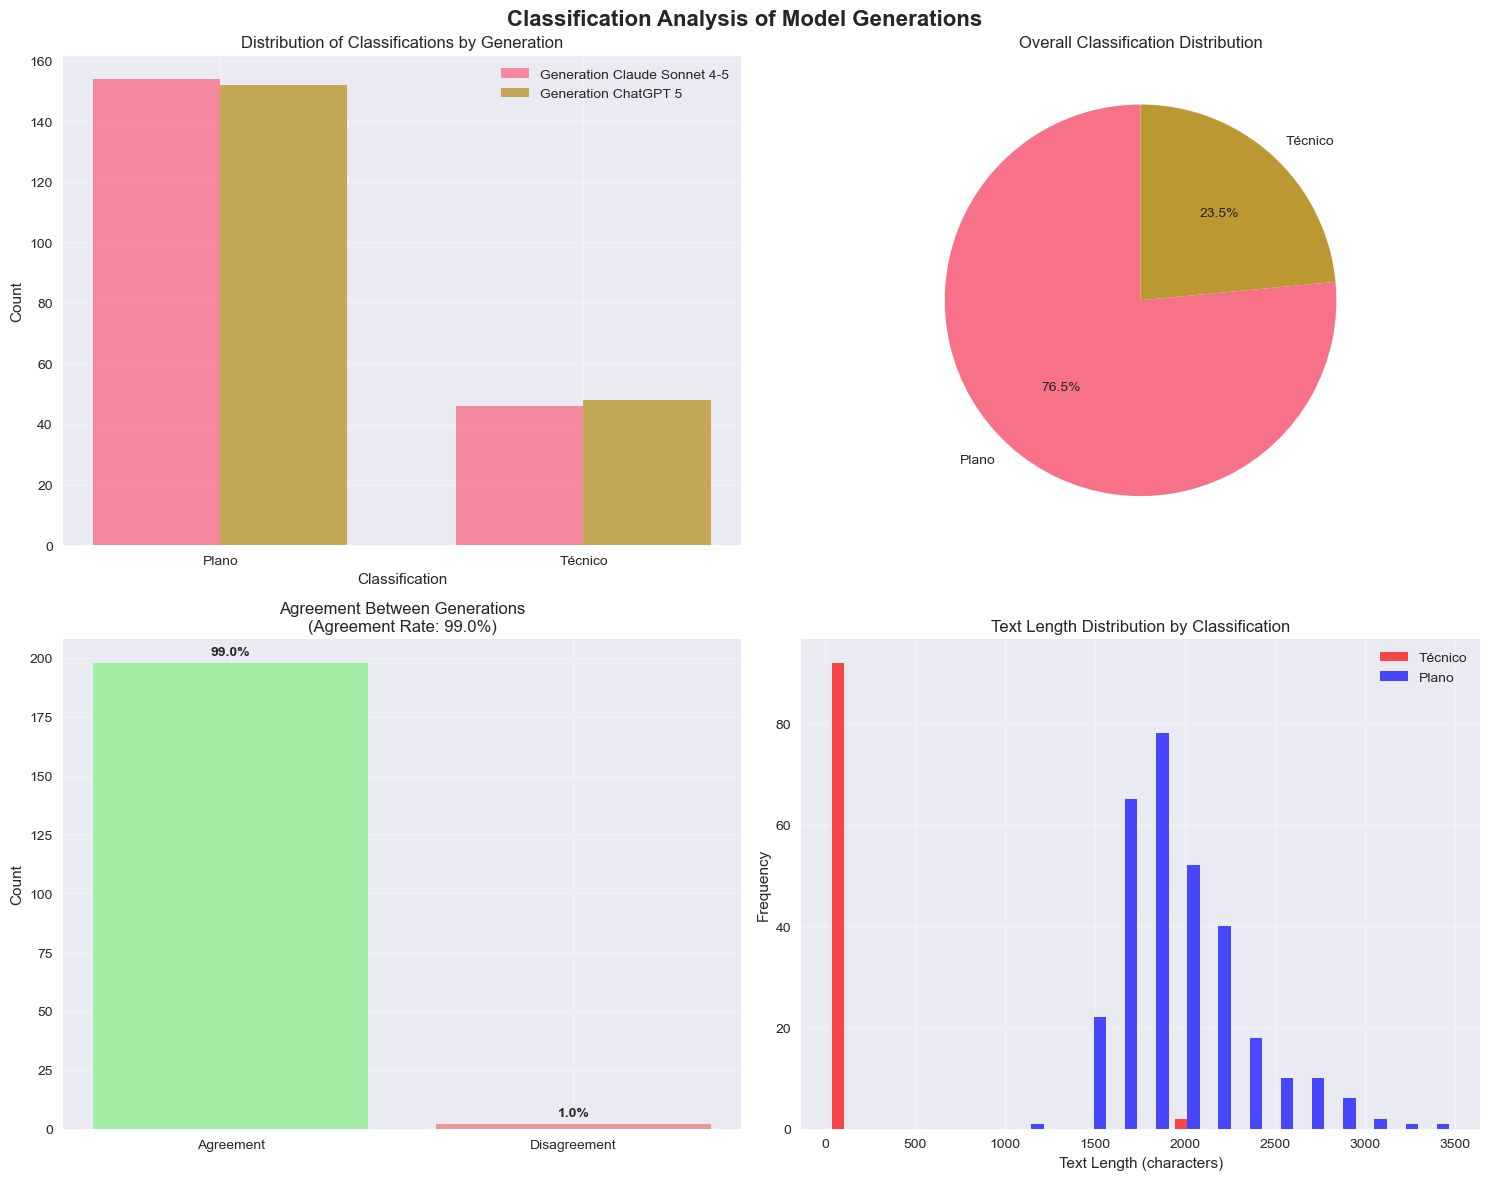

In [6]:
# Set up the plotting environment
plt.rcParams['figure.figsize'] = (12, 8)

# Create subplots for comprehensive analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Classification Analysis of Model Generations', fontsize=16, fontweight='bold')

# Plot 1: Distribution of predictions for each generation
ax1 = axes[0, 0]
if len(available_columns) == 2:
    gen1_counts = results_df['generated_claude-sonnet-4-5_prediction_label'].value_counts()
    gen2_counts = results_df['generated_chatgpt-5_prediction_label'].value_counts()
    
    x = np.arange(len(gen1_counts.index))
    width = 0.35
    
    ax1.bar(x - width/2, gen1_counts.values, width, label='Generation Claude Sonnet 4-5', alpha=0.8)
    ax1.bar(x + width/2, gen2_counts.values, width, label='Generation ChatGPT 5', alpha=0.8)
    ax1.set_xlabel('Classification')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Classifications by Generation')
    ax1.set_xticks(x)
    ax1.set_xticklabels(gen1_counts.index)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    # Single generation column
    col = available_columns[0]
    label_col = f'{col}_prediction_label'
    counts = results_df[label_col].value_counts()
    
    ax1.bar(counts.index, counts.values, alpha=0.8)
    ax1.set_xlabel('Classification')
    ax1.set_ylabel('Count')
    ax1.set_title(f'Distribution of Classifications - {col.replace("_", " ").title()}')
    ax1.grid(True, alpha=0.3)

# Plot 2: Pie chart of overall classification distribution
ax2 = axes[0, 1]
all_predictions = []
for col in available_columns:
    label_col = f'{col}_prediction_label'
    all_predictions.extend(results_df[label_col].dropna().tolist())

if all_predictions:
    unique_labels, counts = np.unique(all_predictions, return_counts=True)
    ax2.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Overall Classification Distribution')

# Plot 3: Agreement between generations (if both exist)
ax3 = axes[1, 0]
if len(available_columns) == 2:
    # Create agreement analysis
    agreement_data = results_df[['generated_claude-sonnet-4-5_prediction_label', 'generated_chatgpt-5_prediction_label']].dropna()
    
    if len(agreement_data) > 0:
        agreement = (agreement_data['generated_claude-sonnet-4-5_prediction_label'] == 
                    agreement_data['generated_chatgpt-5_prediction_label']).mean()
        
        agreement_counts = [
            len(agreement_data[agreement_data['generated_claude-sonnet-4-5_prediction_label'] == 
                              agreement_data['generated_chatgpt-5_prediction_label']]),
            len(agreement_data[agreement_data['generated_claude-sonnet-4-5_prediction_label'] != 
                              agreement_data['generated_chatgpt-5_prediction_label']])
        ]
        
        ax3.bar(['Agreement', 'Disagreement'], agreement_counts, 
                color=['lightgreen', 'lightcoral'], alpha=0.8)
        ax3.set_ylabel('Count')
        ax3.set_title(f'Agreement Between Generations\n(Agreement Rate: {agreement:.1%})')
        ax3.grid(True, alpha=0.3)
        
        # Add percentage labels on bars
        for i, count in enumerate(agreement_counts):
            percentage = count / len(agreement_data) * 100
            ax3.text(i, count + max(agreement_counts) * 0.01, f'{percentage:.1f}%', 
                    ha='center', va='bottom', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Agreement analysis requires\nboth generation columns', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Generation Agreement Analysis')

# Plot 4: Text length distribution by classification
ax4 = axes[1, 1]
if available_columns:
    # Calculate text lengths
    tech_lengths = []
    plain_lengths = []
    
    for col in available_columns:
        text_col = f'{col}_text'
        label_col = f'{col}_prediction_label'
        
        if text_col in results_df.columns and label_col in results_df.columns:
            tech_texts = results_df[results_df[label_col] == 'Técnico'][text_col].dropna()
            plain_texts = results_df[results_df[label_col] == 'Plano'][text_col].dropna()
            
            tech_lengths.extend([len(str(text)) for text in tech_texts])
            plain_lengths.extend([len(str(text)) for text in plain_texts])
    
    if tech_lengths and plain_lengths:
        ax4.hist([tech_lengths, plain_lengths], bins=20, alpha=0.7, 
                label=['Técnico', 'Plano'], color=['red', 'blue'])
        ax4.set_xlabel('Text Length (characters)')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Text Length Distribution by Classification')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No valid text data\nfor length analysis', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

## Step 6: Detailed Statistical Analysis

In [8]:
# Detailed statistical analysis
print("📊 DETAILED STATISTICAL ANALYSIS")
print("=" * 50)

# 1. Basic statistics
print("\n1. BASIC STATISTICS:")
print("-" * 20)
total_valid_predictions = 0
for col in available_columns:
    label_col = f'{col}_prediction_label'
    valid_predictions = results_df[label_col].dropna()
    total_valid_predictions += len(valid_predictions)
    print(f"{col.replace('_', ' ').title()}: {len(valid_predictions)} valid predictions")

print(f"Total valid predictions: {total_valid_predictions}")

# 2. Classification distribution
print("\n2. CLASSIFICATION DISTRIBUTION:")
print("-" * 30)
all_predictions = []
for col in available_columns:
    label_col = f'{col}_prediction_label'
    all_predictions.extend(results_df[label_col].dropna().tolist())

if all_predictions:
    from collections import Counter
    pred_counts = Counter(all_predictions)
    for label, count in pred_counts.items():
        percentage = (count / len(all_predictions)) * 100
        print(f"{label}: {count} ({percentage:.1f}%)")

# 3. Error analysis
print("\n3. ERROR ANALYSIS:")
print("-" * 15)
failed_requests = 0
for col in available_columns:
    label_col = f'{col}_prediction_label'
    failed_count = results_df[label_col].isna().sum()
    failed_requests += failed_count
    print(f"Failed predictions for {col}: {failed_count}")

if total_valid_predictions + failed_requests > 0:
    success_rate = (total_valid_predictions / (total_valid_predictions + failed_requests)) * 100
    print(f"Overall success rate: {success_rate:.1f}%")

# 4. Agreement analysis (if applicable)
if len(available_columns) == 2:
    print("\n4. AGREEMENT ANALYSIS:")
    print("-" * 20)
    
    valid_pairs = results_df[['generated_claude-sonnet-4-5_prediction_label', 'generated_chatgpt-5_prediction_label']].dropna()
    
    if len(valid_pairs) > 0:
        agreement = (valid_pairs['generated_claude-sonnet-4-5_prediction_label'] == 
                    valid_pairs['generated_chatgpt-5_prediction_label']).mean()
        
        print(f"Agreement rate: {agreement:.1%}")
        
        # Confusion matrix style analysis
        print("\nDetailed agreement breakdown:")
        for label1 in ['Técnico', 'Plano']:
            for label2 in ['Técnico', 'Plano']:
                count = len(valid_pairs[
                    (valid_pairs['generated_claude-sonnet-4-5_prediction_label'] == label1) & 
                    (valid_pairs['generated_chatgpt-5_prediction_label'] == label2)
                ])
                print(f"Gen1={label1}, Gen2={label2}: {count}")

# 5. Text length analysis
print("\n5. TEXT LENGTH ANALYSIS:")
print("-" * 25)
for col in available_columns:
    text_col = f'{col}_text'
    label_col = f'{col}_prediction_label'
    
    if text_col in results_df.columns and label_col in results_df.columns:
        print(f"\n{col.replace('_', ' ').title()}:")
        
        for label in ['Técnico', 'Plano']:
            texts = results_df[results_df[label_col] == label][text_col].dropna()
            if len(texts) > 0:
                lengths = [len(str(text)) for text in texts]
                avg_length = np.mean(lengths)
                std_length = np.std(lengths)
                print(f"  {label}: avg length = {avg_length:.0f} ± {std_length:.0f} characters")

📊 DETAILED STATISTICAL ANALYSIS

1. BASIC STATISTICS:
--------------------
Generated Claude-Sonnet-4-5: 200 valid predictions
Generated Chatgpt-5: 200 valid predictions
Total valid predictions: 400

2. CLASSIFICATION DISTRIBUTION:
------------------------------
Plano: 306 (76.5%)
Técnico: 94 (23.5%)

3. ERROR ANALYSIS:
---------------
Failed predictions for generated_claude-sonnet-4-5: 0
Failed predictions for generated_chatgpt-5: 0
Overall success rate: 100.0%

4. AGREEMENT ANALYSIS:
--------------------
Agreement rate: 99.0%

Detailed agreement breakdown:
Gen1=Técnico, Gen2=Técnico: 46
Gen1=Técnico, Gen2=Plano: 0
Gen1=Plano, Gen2=Técnico: 2
Gen1=Plano, Gen2=Plano: 152

5. TEXT LENGTH ANALYSIS:
-------------------------

Generated Claude-Sonnet-4-5:
  Técnico: avg length = 22 ± 0 characters
  Plano: avg length = 1825 ± 197 characters

Generated Chatgpt-5:
  Técnico: avg length = 105 ± 398 characters
  Plano: avg length = 2125 ± 400 characters
